**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources such as [Matteo Courthoud](https://matteocourthoud.github.io/course/ml-econ/01_regression/), Stuti Singh (2020) in Analytics Vidhya,  [Tirthajyoti Sarkar](https://towardsdatascience.com/how-do-you-check-the-quality-of-your-regression-model-in-python-fa61759ff685) and [Jae Kim](https://medium.com/towards-data-science/a-laymans-guide-to-maximum-likelihood-estimation-with-r-code-9e992a10ecd9) in Medium, and databse from Vaibhav Mehta in Github. Every effort has been made to trace copyright holders of the materials used in this notebook. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# 15: Regresión Lineal

La Regresión Lineal (RL) asume que las variables predictoras tienen una distribución Gaussiana y que no son correlacionables, por lo tanto es importante en el análisis de datos explorar estas condiciones. Adicionalmente, hay que tener en cuenta que los modelos de RL son modelos geométricos, es decir que se basan en calcular las distancias entre la predicción y los datos reales, por lo tanto es importante normalizar o estandarizar los datos.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import norm


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

En este Taller utilizaremos la base de datos Boston house-price disponible en [http://lib.stat.cmu.edu/datasets/boston](http://lib.stat.cmu.edu/datasets/boston) para problemas de regresión. La base de datos contiene las siguientes variables:
* CRIM     per capita crime rate by town
* ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS    proportion of non-retail business acres per town
* CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX      nitric oxides concentration (parts per 10 million)
* RM       average number of rooms per dwelling
* AGE      proportion of owner-occupied units built prior to 1940
* DIS      weighted distances to five Boston employment centres
* RAD      index of accessibility to radial highways
* TAX      full-value property-tax rate per \$10,000
* PTRATIO  pupil-teacher ratio by town
* B        $1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town
* LSTAT    % lower status of the population
* MEDV     Median value of owner-occupied homes in $1000's

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

Como se leyeron los datos?
Para X, primero se leyeron las filas pares con todas sus columnas de dos en dos empezando por la fila 0. Luego se leyeron las columnas 1, 2 de todas las filas impares de dos en dos empezando por la fila 1. Y finalmente se juntaron ambas bases de datos con el hstack.
Para y, se leyo la columna 3 de las filas impares.

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1012 non-null   float64
 1   1       1012 non-null   float64
 2   2       1012 non-null   float64
 3   3       506 non-null    float64
 4   4       506 non-null    float64
 5   5       506 non-null    float64
 6   6       506 non-null    float64
 7   7       506 non-null    float64
 8   8       506 non-null    float64
 9   9       506 non-null    float64
 10  10      506 non-null    float64
dtypes: float64(11)
memory usage: 87.1 KB


In [6]:
raw_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8


In [21]:
print(X[0])

[2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
 7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
 9.1400e+00]


In [22]:
print(y[0])

24.0


## Modelo de regresion simple (univariado)

Supongamos que estamos interesados en establecer la relación lineal simple entre y (MEDV) y la columna 4 (RM):

$MEDV \approx \beta_0 + \beta_1 RM$

En este caso sería posible utilizar la herramienta gráfica del _scatterplot_ de la siguiente manera:

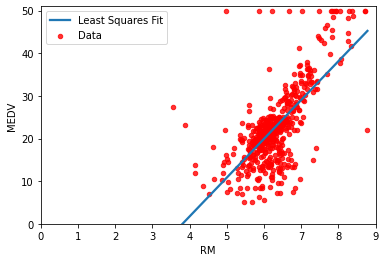

In [ ]:
fig, ax = plt.subplots(1,1)
sns.regplot(x=X[:,5], y=y, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':20})
ax.set_ylabel("MEDV")
ax.set_xlim(0,9)
ax.set_ylim(0,51)
ax.set_xlabel("RM")
ax.legend(['Least Squares Fit','Data']);

### Ordinary Least Square (OLS) estimator

El objetivo de una regresión lineal es obtener los coeficientes que ajusten la función lineal a los datos, es decir el intercepto y la pendiente de la función lineal. Para obtener el mejor ajuste se pueden utilizar diferentes estimadores, entre ellos OLS y Maximum Likelihood Estimator (MLE). Para el caso de la regresión lineal ambos estimadores arrojan el mismo resultado. Mientras MLE busca maximizar la función de probabilidades bajo el modelo estadístico asumido, el OLS busca minimizar el residuo de la suma de los cuadrados (Residual Sum of Squares -RSS-):

$\epsilon_i=y_i-\hat{y}_i$

$RSS=\sum_{n=1}^{N} {\epsilon_i}^2$

En OLS el error no requiere tener una distribución normal, pero si un media de cero, sin embargo tener normalidad en el error implica que los coeficientes también presentan normalidad, por lo tanto nos permite utilizar pruebas de hipótesis. Si los datos son suficientemente grande, no se requiere asumir la normalidad del error por que el teorema del limite central justifica una buena aproximación de los parámetros.

Para el OLS la función de costo es:

$\hat\beta_{OLS}=arg min\sum_{n=1}^{N} (y_i-X_i\beta)^2$

El proceso de encontrar los valores que minimicen u optimicen una función se denomina **optimización**. Para esto en ciencia de datos se puede utilizar una aproximación analítica o una aproximación numérica. La solucion analítica es determinística, es decir que encuentra una solución exacta, lo cual es raro en modelos estadísticos, pero en regresión lineal es posible. con un poco de cálculo derivando la función de costo se llega a esta solución analítica.


$\hat\beta_1=\frac{{}\sum_{i=1}^{n}(X_i-\hat{X})(y_i-\hat{y})}{\sum{i=1}^{n}(X_i-\hat{X})^2}$

y el intercepto:

$\hat\beta_0=\hat{y}-\hat\beta_1\hat{X}$

In [ ]:
B1_num = ((X[:,5] - X[:,5].mean()) * (y - y.mean())).sum()
B1_den = ((X[:,5] - X[:,5].mean())**2).sum()
B1 = B1_num / B1_den
B0 = y.mean() - (B1*X[:,5].mean())
print(B0)
print(B1)

-34.67062077643857
9.10210898118031


Tambien puede estimarse analíticamente de su forma matricial:

$\hat\beta_{OLS}=(X'X)^-1(X'y)$

In [ ]:
x_ols=X[:,5].reshape(-1, 1)
y_ols=y.T
B1 = np.dot(np.linalg.inv(np.dot(x_ols.T,x_ols)),np.dot(x_ols.T,y_ols))
print(B1)

[3.6533504]


Por qué dieron diferente ambos resultados?

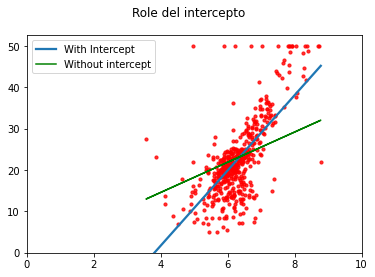

In [ ]:
fig, ax = plt.subplots(1,1)
fig.suptitle('Role del intercepto')
sns.regplot(x=X[:,5], y=y, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':10})
ax.plot(X[:,5], B1*X[:,5], color='g')
plt.xlim(0,10); plt.ylim(ymin=0);
ax.legend(['With Intercept', 'Without intercept']);

In [ ]:
# How to insert intercept? Add constant: column of ones
one = np.ones(np.shape(X[:,5]))
X1 = np.column_stack([one,X[:,5]])
B1 = np.dot(np.linalg.inv(np.dot(X1.T,X1)),np.dot(X1.T,y_ols))
print(B1)

[-34.67062078   9.10210898]


Para calcular el coeficiente de determinación $R^2$ y el coeficiente de correlación $R$ se puede utilizar el coeficiente de correlación de Pearson:

$\rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}$

$r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
	{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}$

In [ ]:
N = len(X[:,5])
num = (N * (X[:,5]*y).sum()) - (X[:,5].sum() * y.sum())
den = np.sqrt((N * (X[:,5]**2).sum() - X[:,5].sum()**2) * (N * (y**2).sum() - y.sum()**2))
R = num / den
print("R: ",R)
print("R2: ",np.sqrt(R))

R:  0.6953599470715396
R2:  0.8338824539894935


Esto significa que el coeficiente de ajuste o determinacion corresponde al cuadrado de la correlacion lineal entre la variable dependiente y la variable independiente.

Para calcular el RSS se puede utilizar:

In [ ]:
from sklearn.preprocessing import scale

# First, scale the data
X5 = scale(X[:,5], with_mean=True, with_std=False).reshape(-1,1)
regr = LinearRegression().fit(X5,y)

# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-5, regr.intercept_+5, 50)
B1 = np.linspace(regr.coef_-0.1, regr.coef_+0.1, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X5.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X5 - y.reshape(-1,1))**2)/1000
min_rss

22.061879196211795

In [ ]:
prediction=regr.predict(X5.reshape(-1,1))
residual=(y-prediction)
RSS=sum(residual**2)
print(RSS)

22061.8791962118


#### Aproximación numérica

Para encontrar los coeficientes de la regresión también se puede utilizar una aproximación numérica, generalmente en ciencia de datos se utiliza el **Gradiente descendente**. el cual es un algoritmo de optimización iterativo de primer orden utilizado para encontrar un mínimo local de una función diferenciable.

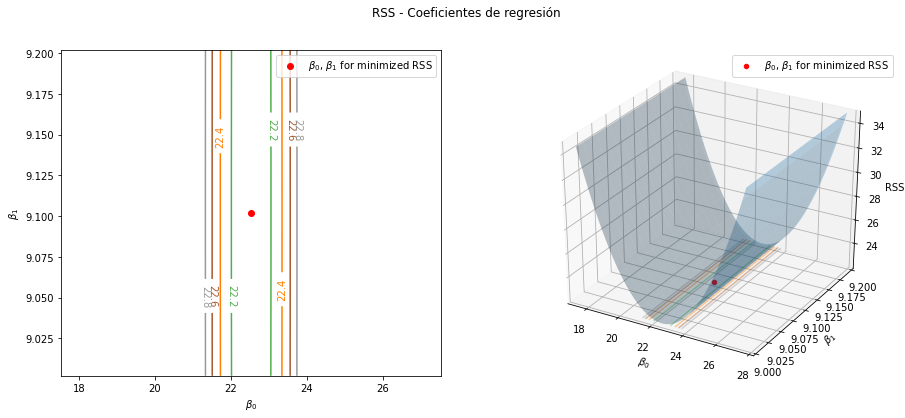

In [ ]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Coeficientes de regresión')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[22, 22.2, 22.4, 22.6, 22.8])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[22, 22.2, 22.4, 22.6, 22.8])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(9,9.2)


# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$')
    ax.set_ylabel(r'$\beta_1$')
    ax.legend()

## Método OLS de la librería *statsmodels*

Aunque la librería mas completa para *machine learning* en Python es Sklearn, existen otras librerías con funciones interesantes, un ejemplo es la librería *statsmodels*. Esta librería permite para los modelos RL obtener un resumen de la implementación del modelo muy útil. A continuación se detalla.

Se importa la librearía como *sm*. Para su implementación, a diferencia de Sklearn, se entrena y posteriormente se aplica la función *fit*.

Finalmente, podemos imprimir con la función *summary* el resultado de la implementación, con métricas muy importantes que permiten conocer el ajuste a los datos.

In [ ]:
import statsmodels.api as sm
lm=sm.OLS(y, X[:,5]).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                              4615.
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                   3.74e-256
Time:                        12:31:45   Log-Likelihood:                         -1747.1
No. Observations:                 506   AIC:                                      3496.
Df Residuals:                     505   BIC:                                      3500.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Con intercepto debemos utilizar la variable X1 que incorpora la constante:

In [ ]:
lm=sm.OLS(y, X1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Thu, 14 Jul 2022   Prob (F-statistic):           2.49e-74
Time:                        23:37:38   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.6706      2.650    -13.084      0.0

Verificar que estos valores de los coeficientes y del intercepto son los mismo que se obtuvieron de forma manual al inicio.

## Maximum Likelihood Estimation (MLE)

Maximum Likelihood Estimation is a statistical method used to estimate the parameters of a probabilistic model based on observed data. The goal of MLE is to find the set of parameter values that maximize the likelihood function, which measures the probability of observing the given data under the assumed model.

1. **Likelihood Function**: The likelihood function, denoted by L(θ | D), is a function of the model parameters θ and the observed data D. It represents the probability of observing the data D given a specific value of the parameters θ. For independent and identically distributed (i.i.d.) data, the likelihood is often expressed as the product of the individual data point probabilities.

2. **Log-Likelihood Function**: In practice, it is common to work with the log-likelihood function, denoted by log L(θ | D), which is the natural logarithm of the likelihood function. Taking the logarithm makes computations easier and helps prevent numerical underflow for large datasets.

3. **MLE Objective**: The MLE objective is to find the parameter values θ that maximize the log-likelihood function:

### Ejemplo
Supongamos que tenemos una serie de datos x = (1, 2, 3), y necesitamos saber la función que generó dichos datos. Si suponemos que dicha función es normal con la siguiente ecuación y con media (μ) y desviación estandar ($σ$)

$\frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}\right)$

Necesitamos solo entonces obtener el valor de μ y $\sigma$. el método de MLE nos permite encontrar dichos valores.

Para eso supomgamos tres distribuciones normales con media 0, 2 y 6, y para simplicidad del problema supongamos desviación estandar de 1 para todas ellas [N(0,1), N(2,1), N(6,1)]. Cual de estas tres funciones normales es mas probable que haya originado los datos?.

(-5.0, 10.0)

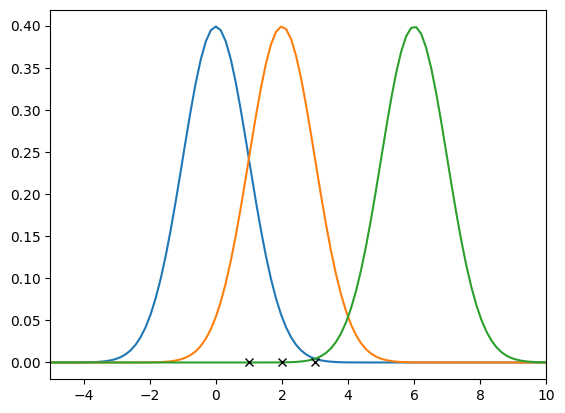

In [3]:
x = np.linspace(-5, 10, 100)
N_0 = norm.pdf(x, loc=0, scale=1)
N_2 = norm.pdf(x, loc=2, scale=1)
N_6 = norm.pdf(x, loc=6, scale=1)
plt.plot(x,N_0)
plt.plot(x,N_2)
plt.plot(x,N_6)
plt.plot(1,0, 'xk')
plt.plot(2,0, 'xk')
plt.plot(3,0, 'xk')
plt.xlim(-5,10)

Como se puede observar en la figura, obviamente la función normal con media 2 y desviación estandar 1 es dicha función. Es decir que dicha funcion maximiza la función de probabilidad.

In [23]:
#datos
x=(1,2,3)
#Para la funcion con media 0 y desviacion 1 la probabilidad de cada valor de x corresponde a
print(norm.pdf(x, loc=0, scale=1))
#Para la funcion con media 2 y desviacion 1 la probabilidad de cada valor de x corresponde a
print(norm.pdf(x, loc=2, scale=1))
#Para la funcion con media 6 y desviacion 1 la probabilidad de cada valor de x corresponde a
print(norm.pdf(x, loc=6, scale=1))

[0.24197072 0.05399097 0.00443185]
[0.24197072 0.39894228 0.24197072]
[1.48671951e-06 1.33830226e-04 4.43184841e-03]


Si se supone que las probabilidades para cada valor son independientes, entonces la probabilidad conjunta (Pμ/x1,x2,x3) es igual al producto de las tres probabilidades:

In [24]:
print(np.prod(norm.pdf(x, loc=0, scale=1)))
print(np.prod(norm.pdf(x, loc=2, scale=1)))
print(np.prod(norm.pdf(x, loc=6, scale=1)))

5.7898701535918536e-05
0.02335800330543158
8.817960516372012e-13


En este caso la función con media 2 y desviacion estandar 1 tienen el mayor valor. A continuación se puede observar de forma gráfica. Generalmente se prefiere utilizar la función logarítmica, ya que es una función monotónica y permite idetificar mejor dicho valor máximo.

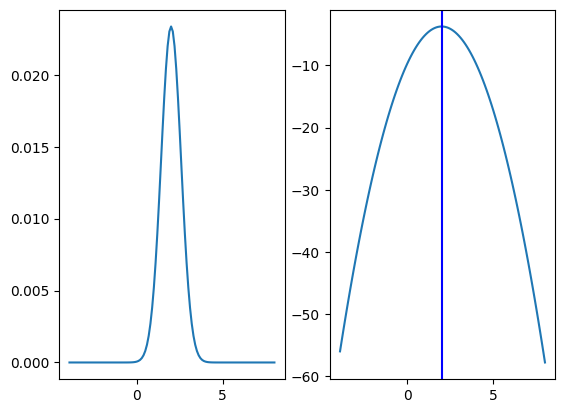

In [25]:
m = np.linspace(-4, 8, 121)
# Plotting likelihood and log-of-likelihood
m1=[None]*len(m)
m2=[None]*len(m)
for i in range(1,len(m)):
  # Likelihood
  m1[i]=np.prod(norm.pdf(x,loc=m[i],scale=1))
  # log-of-Likelihood
  m2[i]=np.log(norm.pdf(x,loc=m[i],scale=1)).sum()

# Likelihood
fig, ax = plt.subplots(1,2)
ax[0].plot(m,m1)
# Log-of-Likelihood
ax[1].plot(m,m2)
plt.axvline(x=2, color='b')

#### Ejemplo
Vamos a generar datos con un función y parámetros conocidos, y comparemos la PDF para los datos generados con los parámetros conocidos y los parámetros estimados de los datos.

In [14]:
# Generating synthetic data from a Gaussian distribution with known parameters
np.random.seed(42)
true_mean = 5.0
true_std = 2.0
num_samples = 100
data = np.random.normal(loc=true_mean, scale=true_std, size=num_samples)

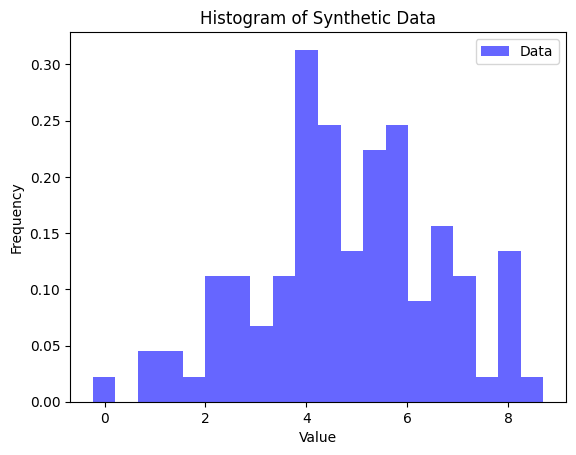

In [15]:
# Visualization of the data distribution
plt.hist(data, bins=20, density=True, alpha=0.6, color='b', label='Data')
plt.title('Histogram of Synthetic Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


A continuación se construyen dos funciones. La primera de ellas para estimar la MLE y la segunda para obtener lso parámetros de la media y desviación estandar a partir de los datos.

In [16]:
# Maximum Likelihood Estimation for Gaussian distribution
def gaussian_likelihood(x, mu, sigma):
    return np.prod(norm.pdf(x, loc=mu, scale=sigma)) #la MLE es igual al producto de la PDF, en este ejemplo de una función normal

# MLE for mean and standard deviation
def maximum_likelihood_estimation(data):
    estimated_mean = np.mean(data)
    estimated_std = np.std(data, ddof=1)  # Using Bessel's correction (ddof=1) for unbiased estimation
    return estimated_mean, estimated_std


In [17]:
estimated_mean, estimated_std = maximum_likelihood_estimation(data)
MLE=gaussian_likelihood(data, estimated_mean, estimated_std)
print(MLE)

4.718350297253985e-88


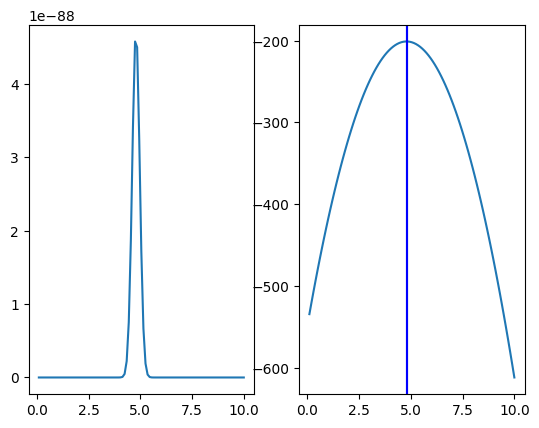

In [22]:
m = np.linspace(0, 10, 100)
m1=[None]*len(m)
m2=[None]*len(m)
for i in range(1,len(m)):
  m1[i]=np.prod(norm.pdf(data,loc=m[i],scale=estimated_std))
  m2[i]=np.log(norm.pdf(data,loc=m[i],scale=estimated_std)).sum()

fig, ax = plt.subplots(1,2)
ax[0].plot(m,m1)
ax[1].plot(m,m2)
plt.axvline(x=estimated_mean, color='b')

Como se puede observar la MLE se maximiza en el valor medio de los datos.

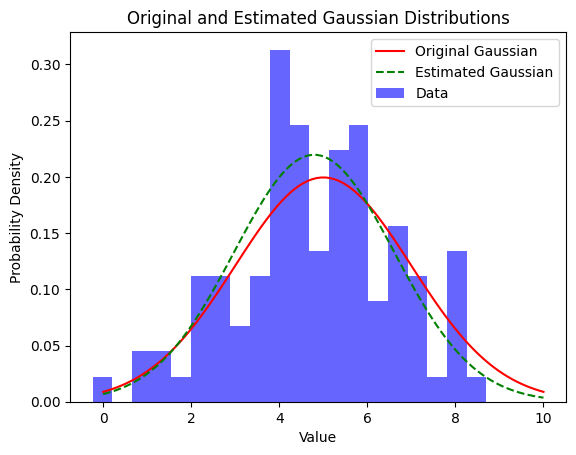

True Mean: 5.0, True Std: 2.0
Estimated Mean: 4.792306965211812, Estimated Std: 1.8163368560156015


In [28]:
# Visualization of the original and estimated Gaussian distributions
x = np.linspace(0, 10, 100)
original_distribution = norm.pdf(x, loc=true_mean, scale=true_std)
estimated_distribution = norm.pdf(x, loc=estimated_mean, scale=estimated_std)

plt.plot(x, original_distribution, 'r', label='Original Gaussian')
plt.plot(x, estimated_distribution, 'g', linestyle='--', label='Estimated Gaussian')
plt.hist(data, bins=20, density=True, alpha=0.6, color='b', label='Data')
plt.title('Original and Estimated Gaussian Distributions')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

print(f"True Mean: {true_mean}, True Std: {true_std}")
print(f"Estimated Mean: {estimated_mean}, Estimated Std: {estimated_std}")

## Modelo de regresión multivariado

In [ ]:
data=pd.read_csv("https://raw.githubusercontent.com/Vaibhav-Mehta-19/linear-regression-weather-dataset/master/weather.csv")
data.head(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,...,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,...,36,1012.4,1008.4,5,3,17.5,25.7,Yes,3.6,Yes


In [ ]:
df=data.dropna()
X=df[["MinTemp", "MaxTemp", "Evaporation", "Sunshine", "Pressure9am"]]
y=df["Rainfall"]
lm=sm.OLS(y, X).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:               Rainfall   R-squared (uncentered):                   0.246
Model:                            OLS   Adj. R-squared (uncentered):              0.235
Method:                 Least Squares   F-statistic:                              21.13
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                    2.78e-18
Time:                        12:32:48   Log-Likelihood:                         -913.70
No. Observations:                 328   AIC:                                      1837.
Df Residuals:                     323   BIC:                                      1856.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

La librearía _statsmodels_ permite utilizar la sintásis [Pasty](https://patsy.readthedocs.io/en/latest/index.html) de la siguiente forma:

In [ ]:
#Con intercepto
import statsmodels.formula.api as smf
lm=smf.ols(formula='Rainfall ~ MinTemp + MaxTemp + Evaporation + Sunshine + Pressure9am', data=df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Rainfall   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     18.01
Date:                Fri, 15 Jul 2022   Prob (F-statistic):           9.45e-16
Time:                        12:32:56   Log-Likelihood:                -902.09
No. Observations:                 328   AIC:                             1816.
Df Residuals:                     322   BIC:                             1839.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     186.6444     38.410      4.859      

In [ ]:
#Para eliminar intercepto
import statsmodels.formula.api as smf
lm=smf.ols(formula='Rainfall ~ MinTemp + MaxTemp + Evaporation + Sunshine + Pressure9am - 1', data=df).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:               Rainfall   R-squared (uncentered):                   0.246
Model:                            OLS   Adj. R-squared (uncentered):              0.235
Method:                 Least Squares   F-statistic:                              21.13
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                    2.78e-18
Time:                        12:33:16   Log-Likelihood:                         -913.70
No. Observations:                 328   AIC:                                      1837.
Df Residuals:                     323   BIC:                                      1856.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

# Interpretation

*Dep. Variable*: Here dependent variable is price that we are going to predict through model.

*Model*: OLS stands for Ordinary Least Squares. Ordinary least squares (OLS) is a type of linear least squares method for estimating the unknown parameters in a linear regression model. OLS selects the parameters of a linear function of a set of explanatory variables by the principle of least squares.

*Method*: Least squares is a standard approach in regression analysis to approximate the solution by minimising the sum of the squares of the residuals.

*No of Observations*: Total no of observations present in dataset.

*Df Residuals*: The df(Residual) is the sample size minus the number of parameters being estimated, so it becomes df(Residual) = n — (k+1).

*R-Squared*: R2 is a statistic that will give some information about the goodness of fit of a model. It ranges from 0 to 1.

*Adj. R Squared*: Each time you add an independent variable to the model, the R-squared increases, even if the independent variable is not significant. It never decreases. Whereas Adjusted R-squared increases only when the independent variable is significant and affects the dependent variable. Adjusted R-square should be used while selecting important predictors (independent variables) for the regression model.

*F-statistics and Prob F-statistics*: The “F value’’ and “Prob(F)’’ statistics test the overall significance of the regression model. Specifically, they test the null hypothesis that all of the regression coefficients are equal to zero.The F value is the ratio of the mean regression sum of squares divided by the mean error sum of squares. Its value will range from zero to an arbitrarily large number. The value of Prob(F) is the probability that the null hypothesis for the full model is true (i.e., that all of the regression coefficients are zero). For example, if Prob(F) has a value of 8.13e-31 then there is almost zero chance in 100 that all of the regression parameters are zero.

*AIC & BIC*: AIC is abbreviation for Akaike’s Information Criteria and is used for model selection. It penalizes the errors mode in case a new variable is added to the regression equation. It is calculated as the number of parameters minus the likelihood of the overall model. A lower AIC implies a better model. Whereas, BIC stands for Bayesian information criteria and is a variant of AIC where penalties are made more severe.

*coef*: Here we have coefficient for const and weights.

*std err*: It shows accuracy for each prediction. Lower the std error better the estimates.

*t & p(t)*: It shows value for t statistics and p value. It involves hypothesis. It answers question as Is it a useful variable or does it help us to explain variability we have in this case. As we know p value </0.05 is considered as variable significant.

*Omnibus/Prob(Omnibus)*: Omnibus test is carried out in order to check whether errors are normally distributed(one of the assumptions of linear regression). Here, the null hypothesis is that the errors are normally distributed. A value close to zero is preferred, that would indicate normality. The Prob (Omnibus) performs a statistical test showing the probability that the residuals are normally distributed. A value close to 1 is preferred here.

*Skew*: Value of Skew is preferred close to zero, indicating the residual distribution is normal. Note that this value also controls the Omnibus.

*Kurtosis*: It is a measure of curvature (peakiness)of the data. Higher peaks lead to greater Kurtosis. Higher value for Kurtosis shows tighter clustering of residuals around zero, implying a better model with few outliers.

*Durbin-Watson*: It tests for homoscedasticity (independance of error). A value between 1 and 2 is preferred.

*Jarque-Bera (JB)/Prob(JB)*: This test is for normality of residual(one of the assumption for linear regression)The test is named after Carlos Jarque and Anil K. Bera. The test statistic is always positive. A large value of Jarque-Bera test shows that the errors are not normally distributed.

*Condition Number*: This test measures the sensitivity of a function’s output as compared to its input. In case of multicollinearity, we can expect much higher fluctuations to small changes in the data.


## Variables predictoras cualitativas

Los modelos de regresión permiten incorporar dentro de su análisis variables predictoras categoricas.

In [ ]:
data["RainTomorrow"].unique()

array(['Yes', 'No'], dtype=object)

Qué pasa si se incluye una variable preditoria binaria a un modelo de regression:

In [ ]:
lm=sm.OLS.from_formula("Rainfall ~ RainTomorrow", data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Rainfall   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     6.614
Date:                Fri, 15 Jul 2022   Prob (F-statistic):             0.0105
Time:                        12:49:22   Log-Likelihood:                -1043.0
No. Observations:                 366   AIC:                             2090.
Df Residuals:                     364   BIC:                             2098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.1640    

Utilicemos una variable categorica politómica:

In [ ]:
data["WindGustDir"].dropna().unique()

array(['NW', 'ENE', 'SSE', 'SE', 'E', 'S', 'N', 'WNW', 'ESE', 'NE', 'NNE',
       'NNW', 'SW', 'W', 'WSW', 'SSW'], dtype=object)

In [ ]:
lm=sm.OLS.from_formula("Rainfall ~ WindGustDir", data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Rainfall   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.6226
Date:                Fri, 15 Jul 2022   Prob (F-statistic):              0.856
Time:                        12:51:51   Log-Likelihood:                -1034.2
No. Observations:                 363   AIC:                             2100.
Df Residuals:                     347   BIC:                             2163.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7189      0

Qué paso con las clases de las variables? cuántas clases tienen la variable y cuantos coeficientes obtuvo en la regresión?

## Transformación de variables

In [ ]:
data.head(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,...,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,...,36,1012.4,1008.4,5,3,17.5,25.7,Yes,3.6,Yes


Los modelos de regresión permiten tranformar variables para mejorar el ajuste o para cumplir con los asumpsiones de la regresión. Por ejmplor es posible cosntruir un modelo de la siguiente forma:

Rainfall ~ $\beta_0 + \beta_1Sunshine + \beta_2Evaporation + \beta_3Pressure9am*Pressure3pm$

In [ ]:
lm=sm.OLS.from_formula("Rainfall ~ Sunshine + Evaporation + Pressure9am*Pressure3pm", data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Rainfall   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     19.62
Date:                Fri, 15 Jul 2022   Prob (F-statistic):           2.84e-17
Time:                        13:01:38   Log-Likelihood:                -991.15
No. Observations:                 363   AIC:                             1994.
Df Residuals:                     357   BIC:                             2018.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                4

Un tipo de transformación común realizado en regresiones para ajustar una variable a un distribución normal es la transformación logarítmica. En este caso se puede realizar de la siguiente manera:

In [ ]:
lm=sm.OLS.from_formula("Rainfall ~ Sunshine + np.log(Evaporation)", data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Rainfall   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     4.594
Date:                Fri, 15 Jul 2022   Prob (F-statistic):             0.0107
Time:                        13:07:15   Log-Likelihood:                -1030.6
No. Observations:                 363   AIC:                             2067.
Df Residuals:                     360   BIC:                             2079.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.6288    

Un caso especial de transformación es la denominada _Box-Cox_ λ. Este tipo de trasnformación se debe realizar previamente de la siguiente manera:

In [ ]:
from scipy import stats
transformed_price, lambda_price = stats.boxcox(data['MaxTemp'])
print(transformed_price)
print(lambda_price)

[5.68489804 5.98395823 5.57641478 4.47695966 4.57214462 4.6954455
 4.88775877 4.7105823  5.07111341 5.50253711 5.79073303 6.02823186
 6.09383808 6.4084763  6.43880013 6.52862048 6.43880013 6.31630958
 6.54835177 6.65544203 6.65544203 5.05730399 4.93082808 5.68489804
 6.14779462 5.98395823 5.42735087 6.10468069 5.68489804 5.6610253
 5.19332287 5.91671672 5.67297812 5.93924321 5.37647051 5.97282128
 5.85989603 6.12628865 6.25383567 5.74401187 4.93082808 5.33790006
 5.17992392 6.00614954 6.30595551 5.2859102  5.36365326 5.25966845
 5.27281017 5.53963596 6.26430668 5.40198783 5.19332287 5.69678527
 5.36365326 5.91671672 5.96165658 6.13705431 6.47893083 6.807088
 6.66506017 6.73185666 6.807088   5.57641478 5.80233592 6.05020653
 6.72237049 6.70334233 6.3472343  6.30595551 6.73185666 6.88118079
 6.87197999 6.69380016 5.50253711 6.69380016 6.63614797 5.77909939
 5.19332287 5.08487567 5.73225314 5.12588345 5.46511118 5.69678527
 6.08296952 5.84844392 6.19050535 6.44886483 6.63614797 6.70334233

In [ ]:
data["transformed_price"]=transformed_price
lm=sm.OLS.from_formula("Rainfall ~ Sunshine + Evaporation + transformed_price", data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Rainfall   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.025
Date:                Fri, 15 Jul 2022   Prob (F-statistic):             0.0296
Time:                        13:24:47   Log-Likelihood:                -1030.7
No. Observations:                 363   AIC:                             2069.
Df Residuals:                     359   BIC:                             2085.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.3267      1.41

Los modelos de regresión lineal permiten incluso incorporar relaciones no lineales de sus variables, de la siguiente forma:

In [ ]:
lm=sm.OLS.from_formula("Rainfall ~ Sunshine + I(Evaporation**2)", data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Rainfall   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     4.244
Date:                Fri, 15 Jul 2022   Prob (F-statistic):             0.0151
Time:                        13:27:10   Log-Likelihood:                -1031.0
No. Observations:                 363   AIC:                             2068.
Df Residuals:                     360   BIC:                             2080.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.8195    

## Evaluación de la regresión

In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

Es posible obtener los valores de Y con el modelo entrenado, utilizando los datos de entrenamiento y los datos de validación. Ademas se puede comparar visualmente el ajuste con los datos reales de validación y las predicciones con los datos de validación.

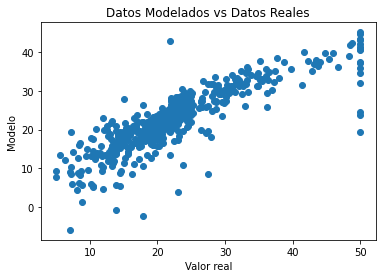

In [ ]:
lm=sm.OLS(y, X).fit()
y_pred=lm.predict(X)
y_test_pred=lm.predict(X)
plt.scatter(y,y_pred)
plt.title('Datos Modelados vs Datos Reales')
plt.xlabel('Valor real')
plt.ylabel('Modelo');

El error residual, es decir la diferencia entre los datos de predicción y las variables predictoras, se distribuye de la siguiente manera para este ejemplo.

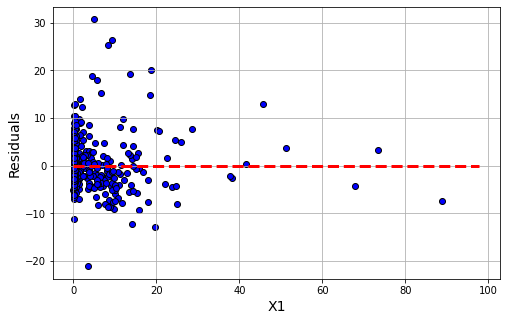

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(x=X[:,0],y=lm.resid,color='blue',edgecolor='k')
plt.grid(True)
xmin=min(X[:,0])
xmax = max(X[:,0])
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.ylabel('Residuals',fontsize=14)
plt.xlabel('X1',fontsize=14)
plt.show()

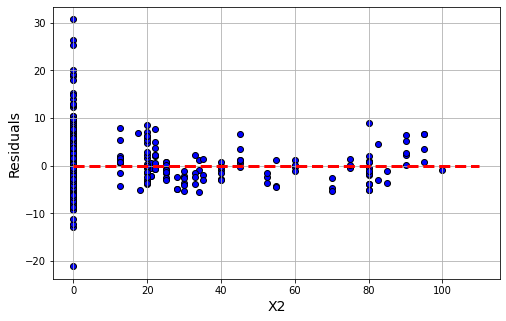

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(x=X[:,1],y=lm.resid,color='blue',edgecolor='k')
plt.grid(True)
xmin=min(X[:,1])
xmax = max(X[:,1])
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.ylabel('Residuals',fontsize=14)
plt.xlabel('X2',fontsize=14)
plt.show()

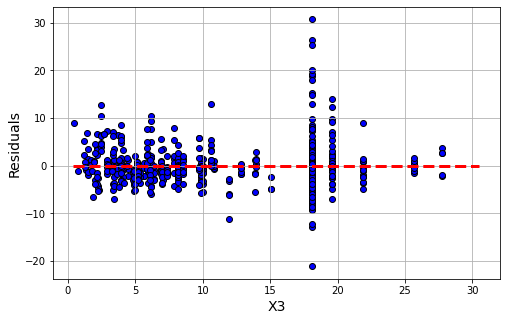

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(x=X[:,2],y=lm.resid,color='blue',edgecolor='k')
plt.grid(True)
xmin=min(X[:,2])
xmax = max(X[:,2])
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.ylabel('Residuals',fontsize=14)
plt.xlabel('X3',fontsize=14)
plt.show()

Residual plots show some bit of clustering but overall the assumptions linearity and independence seem to hold because the distribution seem random around the 0 axis.

## Fitted vs. residuals

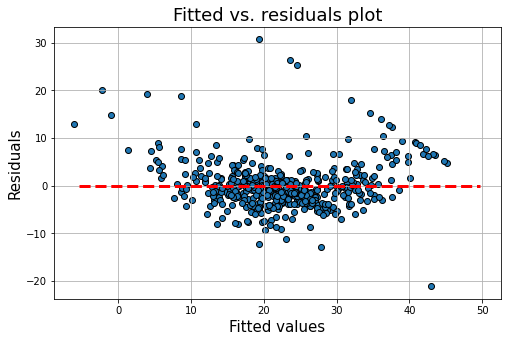

In [ ]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=lm.fittedvalues,y=lm.resid,edgecolor='k')
xmin=min(lm.fittedvalues)
xmax = max(lm.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

##Histogram of normalized residuals

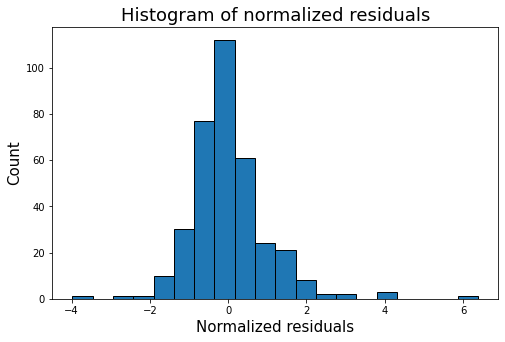

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(lm.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

## Q-Q plot of the residuals

<Figure size 576x360 with 0 Axes>

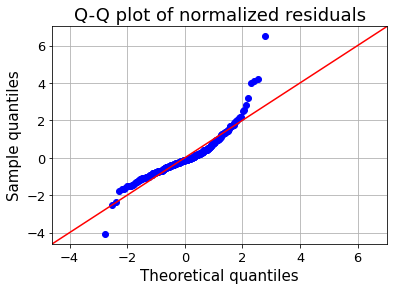

In [ ]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(8,5))
fig=qqplot(lm.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import shapiro
_,p=shapiro(lm.resid)
if p<0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


## Cook's distance (checking for outliers in residuals)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


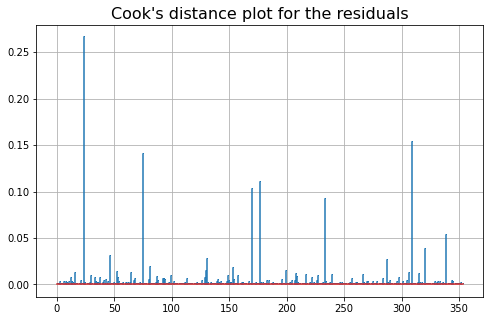

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence
inf=influence(lm)
(c, p) = inf.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()

## Variance inflation factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
for i in range(len(X[0])):
    v=vif(np.matrix(X),i)
    print("Variance inflation factor for x{}: {}".format([i+1],round(v,2)))


Variance inflation factor for x[1]: 2.1
Variance inflation factor for x[2]: 2.84
Variance inflation factor for x[3]: 14.49
Variance inflation factor for x[4]: 1.15
Variance inflation factor for x[5]: 73.89
Variance inflation factor for x[6]: 77.95
Variance inflation factor for x[7]: 21.39
Variance inflation factor for x[8]: 14.7
Variance inflation factor for x[9]: 15.17
Variance inflation factor for x[10]: 61.23
Variance inflation factor for x[11]: 85.03
Variance inflation factor for x[12]: 20.1
Variance inflation factor for x[13]: 11.1


There are several features with VIF > 10, thereby indicating significant multicollinearity

## Métricas

Separamos en datos de entrenamiento y datos de validación con un 30%, y definimos como variables predictoras *X*, y variable dependiente *y*.

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.3)

A continuación se calcula algunas métricas utilizadas en los problemas de regresión, tanto para los datos de entrenamiento, como para los datos de validación. Lo cual permite observar si el modelo presenta problemas de *bias* o de *overfitting*.

In [ ]:
y_train_pred=lm.predict(x_train)
y_test_pred=lm.predict(x_test)

In [ ]:
print('TRAIN MAE:', mean_absolute_error(y_train,y_train_pred))
print('TEST MAE:', mean_absolute_error(y_test,y_test_pred))

TRAIN MAE: 3.314080513202407
TEST MAE: 3.223044008426965


In [ ]:
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

Train RMSE: 4.858323955166733
Test RMSE: 5.047455022973666


In [ ]:
print('R2 Train:',lm.rsquared)
print('R2 Test:',lm.rsquared)

R2 Train: 0.9591890143535311
R2 Test: 0.9591890143535311


In [ ]:
print('R2 Train:',lm.rsquared_adj)
print('R2 Test:',lm.rsquared_adj)

R2 Train: 0.9581128626022043
R2 Test: 0.9581128626022043


## Regresión Lineal con Sklearn

Para implementar los problemas de RL con Sklearn se utiliza el siguiente procedimiento.

In [ ]:
from sklearn.linear_model import LinearRegression

Se instancia el modelo a utilizar, en este caso *LinearRegression* se ajusta a los datos, y finalmente se aplica a los datos de validación para la predicción y conocer el ajuste. Como resultados se pueden obtener el intercepto y los coeficientes de cada variable predictora.

In [ ]:
model = LinearRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Intercepto:',model.intercept_)
print('Coeficientes:',model.coef_)

Intercepto: 34.33409594393511
Coeficientes: [-9.41252682e-02  5.72941297e-02 -1.17959446e-03  2.75352371e+00
 -1.89792057e+01  3.85440454e+00 -5.66414331e-03 -1.54908014e+00
  2.54555049e-01 -7.83084350e-03 -8.93916242e-01  1.03079632e-02
 -4.83491114e-01]


Algunas métricas que se pueden implementar desde *Sklearn* son:

In [ ]:
print('R2:',model.score(x_test,y_test))
print('R2:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('MAE:',mean_absolute_error(y_test,y_pred))

R2: 0.7634955906523349
R2: 0.7634955906523349
MSE: 23.534284246784058
MAE: 3.4467610795433186


También se puede obtener el ajuste visual.

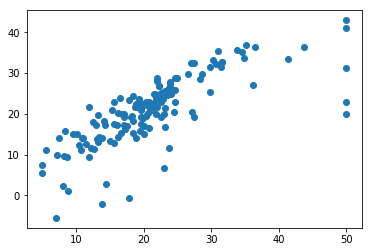

In [ ]:
plt.scatter(y_test,y_pred)
plt.title('Datos Modelados vs Datos Reales')
plt.xlabel('Valor real')
plt.ylabel('Modelo');

Con los datos de entrenamiento se puede implementar el *cross validation* y conocer el ajuste del modelo y su varianza.

In [ ]:
kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
print(results)
print(results.mean())

[ 0.63919994  0.71386698  0.58702344  0.07923081 -0.25294154]
0.35327592439588124


Se obtiene como promedio un valor muy bajor, pero es debido a su gran dispersión. Lo cual se puede observar cuando se modifica el número de *split*.

In [ ]:
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results)
print(results.mean())

[ 0.73376082  0.4730725  -1.00631454  0.64113984  0.54766046  0.73640292
  0.37828386 -0.12922703 -0.76843243  0.4189435 ]
0.2025289900605492


A continuación se presentan los dos modelos de RL con penalización mas conocidos, denominados Lasso (L1) y Ridge (L2).

# Regularización

Uno de las herramientas para reducir los problemas de *overfitting* se refieren a la regularización. En los siguientes ejemplos vamos a observar la aplicación de los métodos de Ridge y Lasso, y el comportamiento del hiperparámetro Lamba para ambos casos.

Inicialmente importamos las librerías:

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

Vamos a trabajar con la base de datos de Sklearn denominada *boston*.

In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]
print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [ ]:
lr=LinearRegression()
lr.fit(X, y)
lr_score = lr.score(X,y)
print('Linear regression score:', lr_score)

Linear regression score: 0.7406077428649427


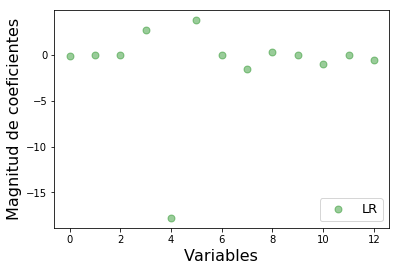

In [ ]:
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='LR')
plt.xlabel('Variables',fontsize=16)
plt.ylabel('Magnitud de coeficientes',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [ ]:
print(lr.coef_)

[-1.07170557e-01  4.63952195e-02  2.08602395e-02  2.68856140e+00
 -1.77957587e+01  3.80475246e+00  7.51061703e-04 -1.47575880e+00
  3.05655038e-01 -1.23293463e-02 -9.53463555e-01  9.39251272e-03
 -5.25466633e-01]


En la figura y matriz anterior se observan los pesos de las 13 variables obtenidas por métodos de regresión linear sin ningún tipo de penalización.

A continuación se implementarán sobre los mismos datos el modelo Ridge y Lasso, los cuales penalizan a traves del hiperparámetro lambda los pesos de cada una de las variables.

### Ridge regression

In [ ]:
rr001 = Ridge(alpha=0.01)
rr001.fit(X, y)
Ridge_score_001 = rr001.score(X,y)
print('Ridge score_001:', Ridge_score_001)

rr = Ridge()
rr.fit(X, y)
Ridge_score = rr.score(X,y)
print('Ridge score_1:', Ridge_score)

rr100 = Ridge(alpha=100)
rr100.fit(X, y)
Ridge_score_100 = rr100.score(X,y)
print('Ridge score_100:', Ridge_score_100)


Ridge score_001: 0.7406072669874482
Ridge score_1: 0.7388294987673955
Ridge score_100: 0.7178124385677699


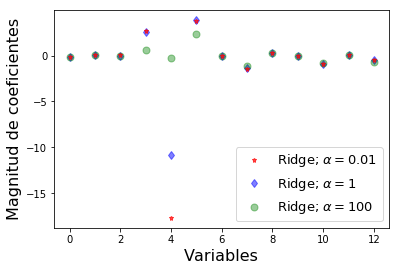

In [ ]:
plt.plot(rr001.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.plot(rr.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 1$') # alpha here is for transparency
plt.plot(rr100.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label=r'Ridge; $\alpha = 100$')
plt.xlabel('Variables',fontsize=16)
plt.ylabel('Magnitud de coeficientes',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

En la figura anterior del modelo Ridge. en el eje X están los índices de los coeficientes, el modelo tiene 13 variables iniciales. Para valores bajos de lambda (0.01), cuando los coeficientes son menos restringidos, la magnitud de los coeficientes es casi similar que para el modelo normal de regresión lineal. Para valores grandes (100), los coeficientes 3, 4 y 5 la magnitud es considerablemente menor comparada al modelo de regresión linear.

A continuación se implementa el modelo *ridge* utilizando la separación simple *train_test* y el *cross validation* para observar la diferencia de resultados entre los coeficientes y el ajuste con la RL normal y *Lasso*. En todos estos casos se utiliza por defecto un valor de *lambda* = 1. Los modelos de RL normal corresponde a cualquiera de los dos métodos, pero con un valor de *lambda*=0. Utilizando la curva de validación se puede obtener el valor óptimo que mejora el ajuste del modelo.

In [ ]:
model = Ridge()

In [ ]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Intercepto:',model.intercept_)
print('Coeficientes:',model.coef_)
print('R2:',r2_score(y_test,y_pred))

Intercepto: 28.0262752082101
Coeficientes: [-8.97936349e-02  5.79959042e-02 -3.81952780e-02  2.59403049e+00
 -9.74745413e+00  3.90387030e+00 -1.43145582e-02 -1.41260458e+00
  2.35286370e-01 -8.70813283e-03 -7.99505049e-01  1.09316575e-02
 -4.89264002e-01]
R2: 0.7628736799283028


In [ ]:
kfold = KFold(n_splits=5, random_state=1)
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results)
print(results.mean())

[ 0.66089569  0.74094893  0.62923672  0.08530169 -0.17029513]
0.38921758241023985


Se observa un mayor ajuste con la separación simple, pero existe una gran varianza en los datos.

### LASSO Regression

Este tipo de regularización (L1) puede reducir completamente la importancia de las variables hasta 0, por lo tanto no solamente se utiliza para reducir el sobreajuste en un modelo, sino ademas como método de selección de variables.. El parémetro por defecto de la regularización Lasso es 1.

A continuación se implementará el modelo Lasso.

In [ ]:
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X,y)
lasso_score001=lasso001.score(X,y)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("Lasso score para alpha=0.01 es", lasso_score001)
print ("Número de variables utilizadas para alpha =0.01:", coeff_used001)
print(lasso001.coef_)

lasso = Lasso()
lasso.fit(X,y)
lasso_score_1=lasso.score(X,y)
coeff_used = np.sum(lasso.coef_!=0)
print ("Lasso score para alpha=1 es", lasso_score_1)
print ("Número de variables utilizadas para alpha =1: ", coeff_used)
print(lasso.coef_)

lasso100 = Lasso(alpha=100, max_iter=10e5)
lasso100.fit(X,y)
lasso_score100=lasso100.score(X,y)
coeff_used100 = np.sum(lasso100.coef_!=0)
print ("Lasso score para alpha=100 es", lasso_score100)
print ("Número de variables utilizadas para alpha =100:", coeff_used100)
print(lasso100.coef_)

Lasso score para alpha=0.01 es 0.7401747367311462
Número de variables utilizadas para alpha =0.01: 13
[-1.05330983e-01  4.68329072e-02  6.77570009e-03  2.50607938e+00
 -1.44226291e+01  3.80918476e+00 -1.76057409e-03 -1.42229358e+00
  2.98099885e-01 -1.26220655e-02 -9.17066833e-01  9.56558992e-03
 -5.31194326e-01]
Lasso score para alpha=1 es 0.6825494617506651
Número de variables utilizadas para alpha =1:  10
[-0.06342255  0.04916867 -0.          0.         -0.          0.94678567
  0.02092737 -0.66900864  0.26417501 -0.01520915 -0.72319901  0.00829117
 -0.76143296]
Lasso score para alpha=100 es 0.22497922550751603
Número de variables utilizadas para alpha =100: 2
[-0.          0.         -0.          0.         -0.          0.
 -0.          0.         -0.         -0.02097192 -0.          0.00446643
 -0.        ]


En el caso anterior, cuando se incrementa el valor de lambda a 100, los pesos de los parámetros se reducen de tal forma que solo dos variables (11 y 12) permanecen con valores ligéramente diferentes a 0.

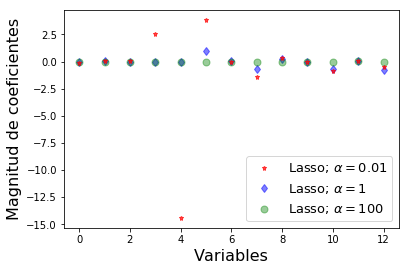

In [ ]:
plt.plot(lasso001.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.plot(lasso.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 1$') # alpha here is for transparency
plt.plot(lasso100.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label=r'Lasso; $\alpha = 100$')
plt.xlabel('Variables',fontsize=16)
plt.ylabel('Magnitud de coeficientes',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

De forma similar se implementa el RL tipo *lasso*.

In [ ]:
from sklearn.linear_model import Lasso
model = Lasso()

In [ ]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print('Intercepto:',model.intercept_)
print('Coeficientes:',model.coef_)
print('R2:',r2_score(y_test,y_pred))

Intercepto: 38.202168185895495
Coeficientes: [-0.03790178  0.0608616  -0.0045888   0.         -0.          1.007868
  0.01097365 -0.78931757  0.21562959 -0.0116075  -0.63992023  0.00979854
 -0.73309521]
R2: 0.715480373563341


In [ ]:
kfold = KFold(n_splits=5, random_state=1)
results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(results)
print(results.mean())

[0.56156843 0.63385562 0.33456629 0.35466066 0.27459294]
0.431848787926522


Similares resultados en términos de varianza para el modelo *lasso*, sin embargo se observa un valor mayor de ajuste para la *cross validation*. en este aso es muy importante elaborar la curva de entrenamiento y entender como el modelo aprende de acuerdo con los datos.